In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dados = np.load("/content/mimic_X_y_mask_4h_bal.npz")

# Extraindo os arrays
X_bal = dados["X"]
y_bal = dados["y"]
mask_bal = dados["mask"]

print("Dados carregados da versão balanceada")
print(f"Total de amostras: {len(y_bal)}")
print(f"Com Sepse: {np.sum(y_bal == 1)}")
print(f"Sem Sepse: {np.sum(y_bal == 0)}")

Dados carregados da versão balanceada
Total de amostras: 14124
Com Sepse: 7062
Sem Sepse: 7062


In [3]:
# Divisão treino + temp (validação+teste)
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    X_bal, y_bal, mask_bal, test_size=0.30, random_state=42, stratify=y_bal
)

# Divisão temp => validação e teste (50/50% de 30%)
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# --- Normalização segura por feature ---
def normalize_split_data(X_train, X_val, X_test):
    n_samples, n_janelas, n_features = X_train.shape
    X_train_norm = np.zeros_like(X_train)
    X_val_norm = np.zeros_like(X_val)
    X_test_norm = np.zeros_like(X_test)
    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        feat_train = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(feat_train)

        X_train_norm[:, :, i] = scaler.transform(feat_train).reshape(n_samples, n_janelas)
        X_val_norm[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], n_janelas)
        X_test_norm[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test.shape[0], n_janelas)

        scalers.append(scaler)

    return X_train_norm, X_val_norm, X_test_norm, scalers

# Executar normalização
X_train_norm, X_val_norm, X_test_norm, scalers = normalize_split_data(X_train, X_val, X_test)

# Salvar scalers
joblib.dump(scalers, "scalers_standard_lstm.pkl")

# Atualizar variáveis do pipeline
X_train, X_val, X_test = X_train_norm, X_val_norm, X_test_norm

# Forma da entrada
input_shape = X_train.shape[1:]

# Definição do modelo LSTM
inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5994 - auc: 0.6398 - loss: 0.7290 - precision: 0.6610 - recall: 0.4046 - val_accuracy: 0.6895 - val_auc: 0.7401 - val_loss: 0.6554 - val_precision: 0.6978 - val_recall: 0.6689
Epoch 2/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6783 - auc: 0.7336 - loss: 0.6594 - precision: 0.6940 - recall: 0.6446 - val_accuracy: 0.6942 - val_auc: 0.7505 - val_loss: 0.6417 - val_precision: 0.7098 - val_recall: 0.6575
Epoch 3/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6840 - auc: 0.7419 - loss: 0.6449 - precision: 0.6998 - recall: 0.6310 - val_accuracy: 0.6928 - val_auc: 0.7545 - val_loss: 0.6350 - val_precision: 0.7097 - val_recall: 0.6528
Epoch 4/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6846 - auc: 0.7439 - loss: 0.6391 - precision: 0.7067 - recall: 0.6341 - val_accuracy: 0.6895 - val_auc: 0.7559 - val_loss: 0.6279 - val_precision: 0.7111 - val_recall: 0.6387
Epoch 5/70
309/309 ━━━━━━━

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Acurácia: 0.7206
AUC: 0.7766
Precisão: 0.7102
Revocação: 0.7450
F1-score: 0.7272


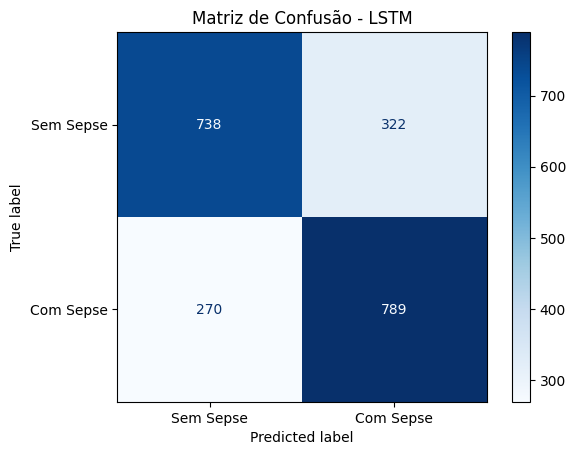

In [4]:
# Previsão das probabilidades no conjunto de teste
y_pred_prob = model.predict(X_test).flatten()

# Limiar de classificação
limiar = 0.5
y_pred = (y_pred_prob >= limiar).astype(int)

from sklearn.metrics import accuracy_score;
# Cálculo das métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem Sepse", "Com Sepse"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM")
plt.show()

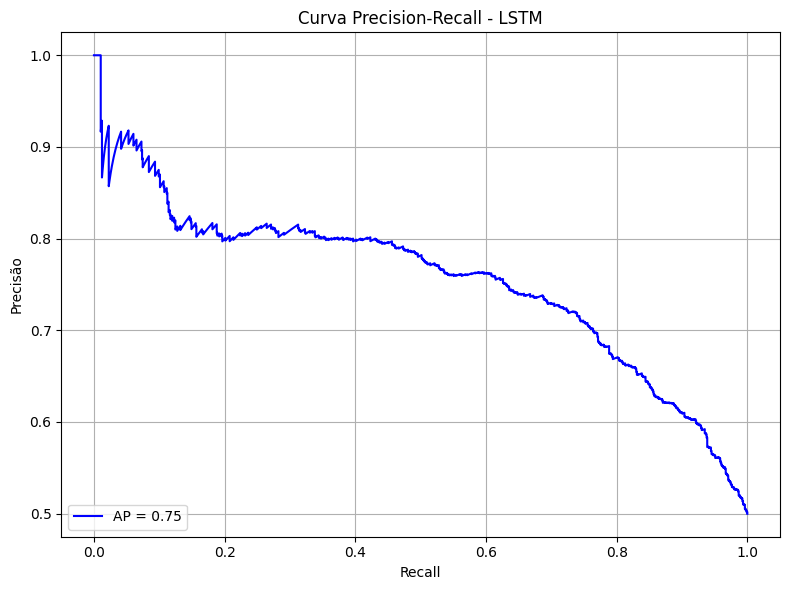

In [5]:
# Curva Precision-Recall com dados de teste
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()